# Predicting Critical Health and Safety Violations at Food Establishments

<p>As a destination that attracts millions of tourists every year, Southern Nevada, and particularly Las Vegas, offers many possibilities when it comes to dining options. With food offerings that range from family owned locales to Michelin star restaurants, the choices may seem endless. This can be a great experience for visitors, but a challenging task for the Southern Nevada Health District, as it must inspect every establishment to ensure that it meets the food and safety requirements to protect the public’ health.</p>
<p>Using publicly available data from restaurant inspection results and Yelp’s data on businesses and consumers’ ratings, the objective of this report is to look at the data and create the first part of this story.</p>

# Set up the Enviroment

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import necessary modules
import pandas as pd
from pandas.io.json import json_normalize
import json
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import requests
import re
import numpy as np

# Collect Restaurant Inspections Data

In [3]:
# get the url to collect the data
url = 'https://opendata.lasvegasnevada.gov/resource/86jg-3buh.json?$limit=168161'

# package the request, send the request and catch the response
r = requests.get(url)

In [4]:
# get the text from the url
txt = r.text

# look at the structure
print(type(txt))
print(len(txt))   # get an idea of how long is the text before displaying it
print(txt[:20])

<class 'str'>
120764616
[{"address":"4000 W 


In [5]:
# convert the text into a json file
json_file = r.json()

In [6]:
# look at the trype and structure
print(len(json_file))
print(type(json_file))
print(json_file[0])

168161
<class 'list'>
{'address': '4000 W Flamingo Rd', 'category_name': 'Bar / Tavern', 'city': 'Las Vegas', 'current_demerits': '5', 'current_grade': 'A', 'date_current': '2017-08-07T00:00:00.000', 'employee_id': 'EE7001214', 'inspection_date': '2017-08-07T00:00:00.000', 'inspection_demerits': '5', 'inspection_grade': 'A', 'inspection_result': "'A' Grade", 'inspection_time': '2017-08-07T15:20:00.000', 'inspection_type': 'Routine Inspection', 'location_1': {'type': 'Point', 'coordinates': [115.1929046, 36.1166353]}, 'location_name': 'Gold Coast Hotel & Casino', 'permit_number': 'PR0006774', 'permit_status': 'A', 'record_updated': '2017-08-08T09:31:16.000', 'restaurant_name': 'Gold Coast Bingo Service Bar', 'serial_number': 'DA0EHXVCT', 'state': 'Nevada', 'violations': '209', 'zip': '89103-4004'}


In [7]:
# since it's a list of dictionaries, use normalization to change the data structure into a flat table
data = json_normalize(json_file)

In [8]:
# confirm files was loaded successfully
print(data.shape)
data.head(2)

(168161, 24)


,address,category_name,city,current_demerits,current_grade,date_current,employee_id,inspection_date,inspection_demerits,inspection_grade,...,location_1.type,location_name,permit_number,permit_status,record_updated,restaurant_name,serial_number,state,violations,zip
0,4000 W Flamingo Rd,Bar / Tavern,Las Vegas,5,A,2017-08-07T00:00:00.000,EE7001214,2017-08-07T00:00:00.000,5,A,...,Point,Gold Coast Hotel & Casino,PR0006774,A,2017-08-08T09:31:16.000,Gold Coast Bingo Service Bar,DA0EHXVCT,Nevada,209,89103-4004
1,1237 Nevada Hwy,Restaurant,Boulder City,5,A,2017-08-08T00:00:00.000,EE7001020,2017-08-08T00:00:00.000,5,A,...,Point,McDonald's Restaurant,PR0002776,A,2017-08-08T08:52:21.000,McDonald's Restaurant #7790,DA0J0HTDI,Nevada,"202,2927",89005-1809


In [9]:
# remove leading and trailing spaces from the column names 
data.columns = data.columns.str.strip('')

In [10]:
# subset the dataset to relevant columns
nv = data.copy()[['address', 'category_name', 'city', 'current_demerits', 'current_grade','employee_id',
                 'inspection_date', 'inspection_time','inspection_demerits','inspection_grade', 'inspection_result',
                  'violations', 'inspection_type', 'location_1.coordinates','location_name',
                  'permit_status', 'restaurant_name', 'zip']]
print(nv.shape)

(168161, 18)


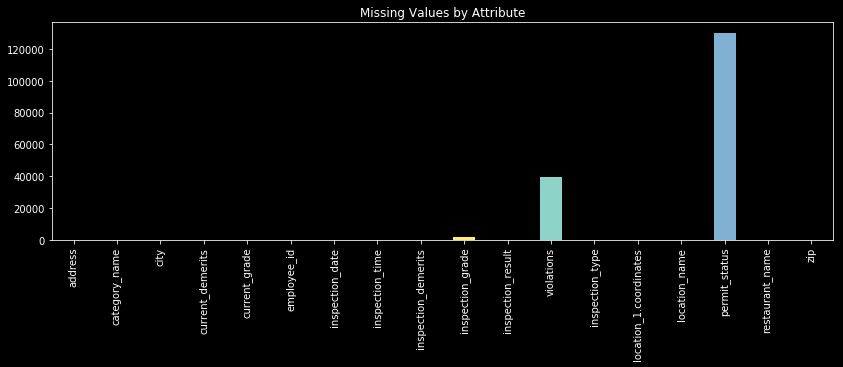

In [13]:
# Look at column types, number of missing values by column and chose best column for target variable
# inspection result has less missing values
plt.rcParams["figure.figsize"] = [14,4]
plt.title('Missing Values by Attribute')
plt.style.use(['dark_background'])
nv.isna().sum().plot(kind = 'bar')

In [14]:
nv.isna().sum()

address                       63
category_name                  0
city                          18
current_demerits               0
current_grade                 28
employee_id                    0
inspection_date                0
inspection_time               47
inspection_demerits            0
inspection_grade            1700
inspection_result              0
violations                 39347
inspection_type                0
location_1.coordinates         0
location_name                 10
permit_status             130205
restaurant_name                3
zip                           19
dtype: int64

***
## Data Wrangling

In [19]:
# define functions to clean datasets

def col_cleanup(df, cols_list= None):
    """Returns column values in lower case
     a copy of the string with the leading and trailing characters removed."""
    for i in cols_list:
        df[i] = df[i].str.lower()
    df.columns = [x.strip() for x in df.columns]
    return df

#remove special characters from name
def rm_special_char(column):
    """ Find and remove special characters and spaces from defined column """
    pattern1 = re.compile('\#\d*')
    pattern2 = re.compile('[a-z]')
    try:
        if pattern2.match(column):
            y = re.findall(pattern = pattern1,string = column)[0]
            return column.replace(y,"").strip(" ")
        else:
            return column
    except:
        return column
    
# create a separate column for month and year.
def split_dates(df, col_date = None):
    """Split date to do the merge"""
    df[col_date] = pd.to_datetime(df[col_date])
    df['year_str'] = df[col_date].dt.year
    df['month_str'] = df[col_date].dt.month
    return df

# based on inspection results create the target variable
def target(df):
    """Use conditional statement to create target variable"""
    if df['inspection_result'] == "compliant":
        return "1"
    elif df['inspection_result'] == "'a' grade":
        return "1"
    elif df['inspection_result'] == 'approved':
        return "1"
    elif df['inspection_result'] == "no further action":
        return "1"
    elif df['inspection_result'] == 'unspecified' and df['inspection_grade'] == 'A':#and df['current_grade'] == 'A':
        return "1"
    else:
        return "0"

## Clean Inspection Results Data

In [20]:
#remove spaces from a list of columns
nv = col_cleanup(nv, cols_list= ['address', 'restaurant_name','inspection_result'])

# create a new column with special characters remove from restaurant name
nv['clean_name']= rm_special_char(nv['restaurant_name'])

# create month and year columns using the split_dates function
nv = split_dates(nv, col_date = 'inspection_date')

# create a zip-code column with the first part of the zip column 
nv['zip_code'] = nv['zip'].str.split('-').str[0]

# apply target function to creat the target variable
nv['is_compliant'] = nv.apply (lambda df: target (df),axis=1)

In [21]:
# confirm data is complet
nv.shape

(168161, 23)

## Save Clean Copy

In [ ]:
nv.to_csv('nv_inspections.csv', sep = ',', chunksize = 1000, index = False)

# Data Story Restaurant Inspections

## Where Inspection Priorities Lie

#### Who gets the most inspections?

For inspection purposes, food establishments are classified into different categories based on the type of facility and food service they provide.  This categorization can help distinguish not only how and when establishments can operate, but also how they prepare and handle food, which can be further used to analyze inspection results.  

Based on the data, the Southern Nevada Health District uses 30 categories to distinguish food establishments. So, which ones get the most inspections? Not surprisingly, as shown in the graph below, <b>restaurants account for the majority of inspections, followed by bars, snack bars, specialty kitchens, and elementary school kitchens</b>. Among the establishments with the least number of inspections are childcare kitchens, banquet support, beer bars, and Farmer’s markets.

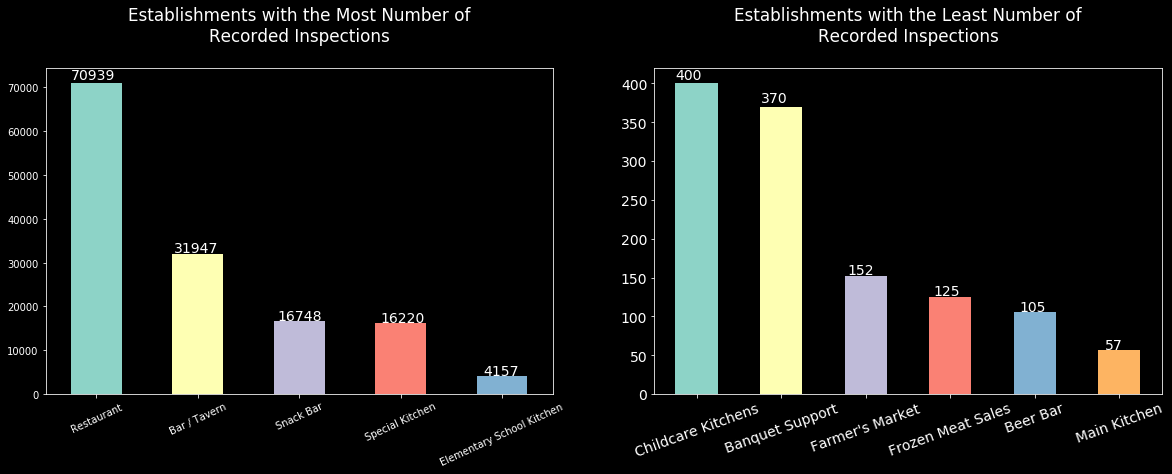

In [22]:
# set figure size, background and position of first plot
plt.rcParams["figure.figsize"] = [20,6]
plt.style.use(['dark_background'])
plt.subplot(1,2,1)

# set font size and title
plt.rcParams.update({'font.size': 14})
plt.title('Establishments with the Most Number of\nRecorded Inspections\n')

# plot first plot and add counts at the top of the bars
ax = nv.category_name.value_counts().head(5).plot(kind = 'bar', rot = 25)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.018, p.get_height() * 1.015))

# set figure size and position of second plot   
plt.rcParams["figure.figsize"] = [8,10]
plt.subplot(1,2,2)

# set title and plot bottom six and add the counts on top of the bars
plt.title('Establishments with the Least Number of\nRecorded Inspections\n')
ax = nv.category_name.value_counts().tail(6).plot(kind = 'bar', rot = 20)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.018, p.get_height() * 1.015))

### How many are re-inspections?
However, not all inspections are equal. Establishments get routine inspections, but they also get can get a second inspection if they fail their first inspection. So, how many of the total inspections are re-inspections? As shown in the bar graph below, the large majority of inspections are routine inspections and only a small number of re-inspections. This shows the large majority of establishments are compliant.

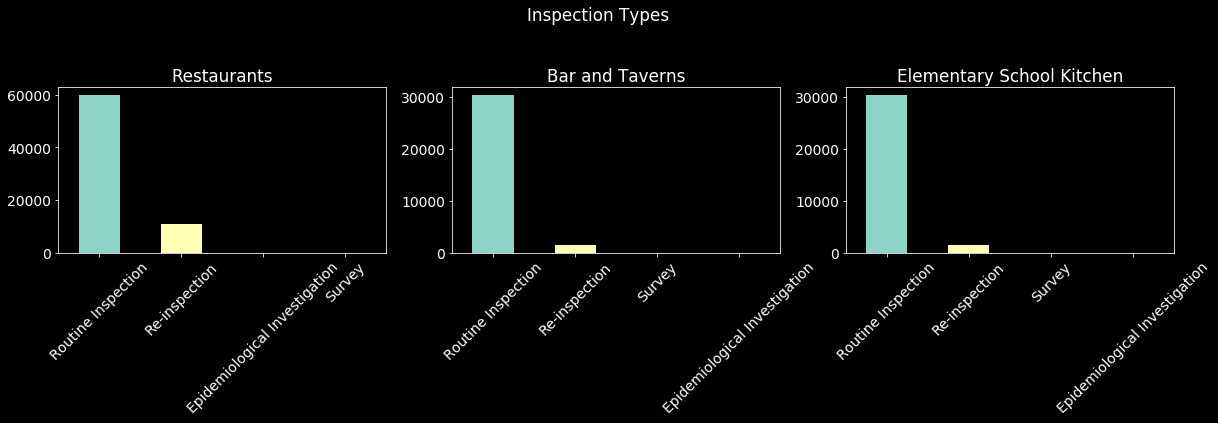

In [23]:
# subset top establisments to plot
r = nv.loc[nv['category_name']=='Restaurant']
b = nv.loc[nv['category_name']=='Bar / Tavern']
e = nv.loc[nv['category_name']=='Elementary School Kitchen']

# set figure size, main title and location of main title
plt.rcParams["figure.figsize"] = [20,4]
plt.suptitle('Inspection Types')
plt.subplots_adjust(top=.7)

# set the layout and position of plots
plt.subplot(1,3,1)

# plot inspection types for restaurants
r['inspection_type'].value_counts().plot(kind = 'bar', rot = 45)
plt.title('Restaurants')

# plot inspection types for 'Bar / Tavern'
plt.subplot(1,3,2)
b['inspection_type'].value_counts().plot(kind = 'bar', rot = 45)
plt.title('Bar and Taverns')

# plot inspection types for 'Elementary School Kitchen'
plt.subplot(1,3,3)
plt.title('Elementary School Kitchen')
b['inspection_type'].value_counts().plot(kind = 'bar', rot = 45)

<b>Inspection Types for Establishment with Least Number of Inspections</b>

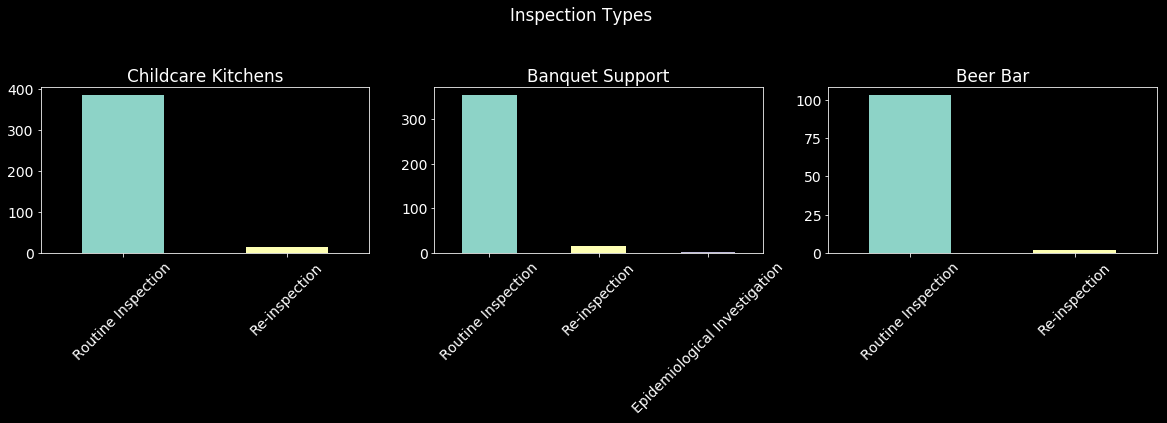

In [24]:
# subset establishments to plot
childcare = nv.loc[nv['category_name']=='Childcare Kitchens']
banquet = nv.loc[nv['category_name']=='Banquet Support']
beer = nv.loc[nv['category_name']=='Beer Bar']

# set figure size, main title and location of main title
plt.rcParams["figure.figsize"] = [20,4]
plt.suptitle('Inspection Types')
plt.subplots_adjust(top=.7)

# set the layout and position of plots
plt.subplot(1,3,1)

# plot inspection types for childcare kitchens
childcare['inspection_type'].value_counts().plot(kind = 'bar', rot = 45)
plt.title('Childcare Kitchens')

# # plot inspection types for banquet support
plt.subplot(1,3,2)
banquet['inspection_type'].value_counts().plot(kind = 'bar', rot = 45)
plt.title('Banquet Support')

# plot inspection types for beer bars
plt.subplot(1,3,3)
plt.title('Beer Bar')
beer['inspection_type'].value_counts().plot(kind = 'bar', rot = 45)

## What's in a Grade?

Each establishment receives a grade during an inspection based on the number and type of violations. Each violation is assigned a value (demerit), that results in a grade. Establishments with less than 10 demerits receive an ‘A’, meaning, they are compliant, while ‘B’s (11 – 20) and ‘C’s (21-40) are downgrades and indicate critical or major violations. However, as shown in the graph below, inspections can have other scores or no score, and only the inspection result type is logged. Hence, there are at least 10 possible letter grades and 25 inspection result categories.
<p>A possible issue with such a wide range of grades and inspection results is that it can create inconsistency in the inspection results, as inspectors who find similar violations could record them differently.</p>

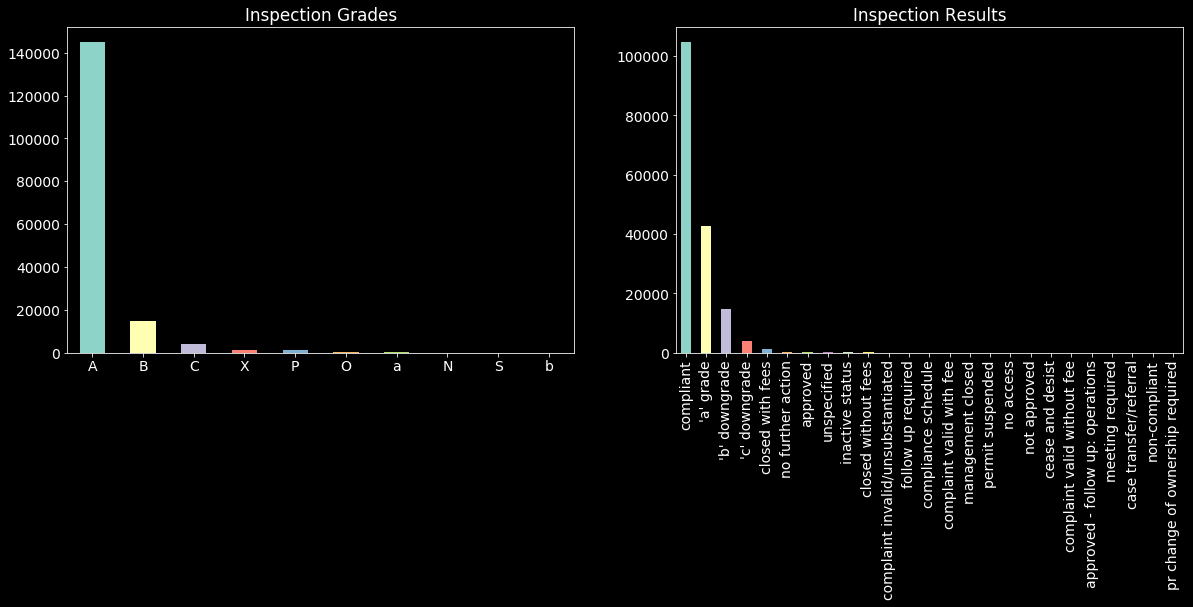

In [25]:
# set the figure size and location of the first plot
plt.rcParams["figure.figsize"] = [20,6]
plt.subplot(1,2,1)

# plot count of inspection grades
nv['inspection_grade'].value_counts().plot(kind = 'bar', rot = 0)
plt.title('Inspection Grades')

# set the size and position of second plot
plt.rcParams["figure.figsize"] = [20,8]
plt.subplot(1,2,2)

# plot inspection counts
plt.title('Inspection Results')
nv['inspection_result'].value_counts().plot(kind = 'bar')

### Relationship between Violation Points and Inspection Grades over time

The graph below shows that the number of violation points (demerits) by the main grades (A, B, C) has been consistent overtime, with B grades having between 8 and 20 points.

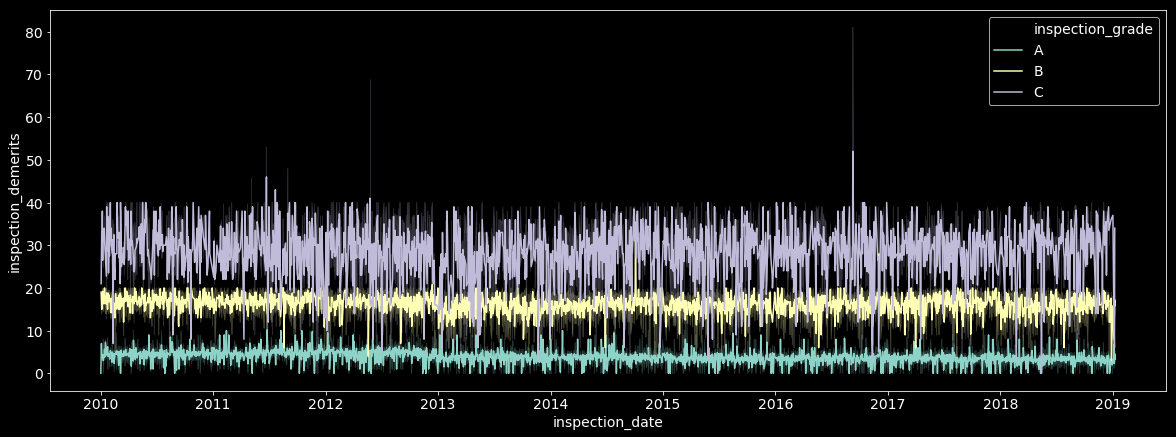

In [33]:
# subset main grades
rows = ['A', 'B', 'C']
nv['inspection_demerits']=pd.to_numeric(nv.inspection_demerits)
short = nv[(nv['inspection_grade'].isin(rows))]# & (nv['inspection_date']>='2015')]

# set plot parameters and plot using seaborn
plt.rcParams["figure.figsize"] = [20,7]
sns.lineplot(x='inspection_date', y='inspection_demerits', hue="inspection_grade", data=short)

### Are Grades Improving over Time?

Although A grades seem to be up and down over time, and even seem to be decreasing between 2016 and 2017, a closer look at the total number of inspections over time, as shown in the graphs below, shows that the frequency of inspections matches the number of grades. Hence, grades have been stable over time and when inspections go down, so do inspection grades.

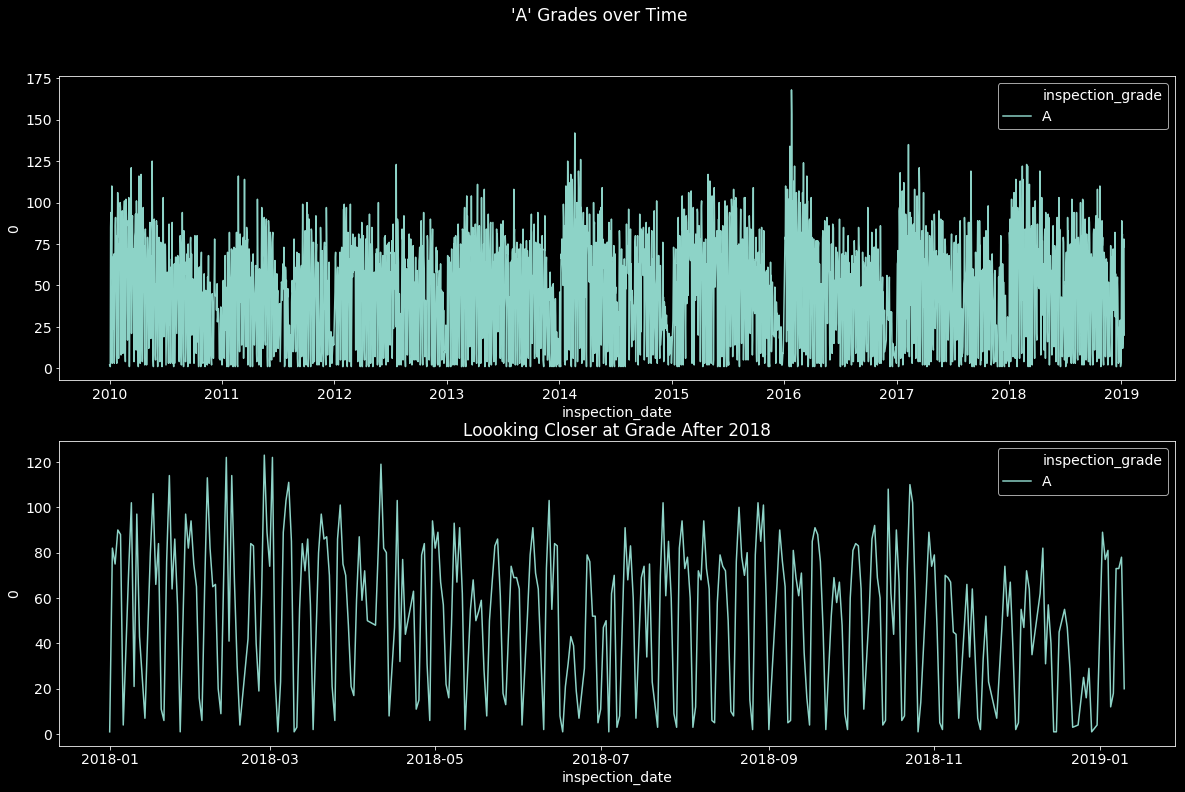

In [36]:
# subset A grades
a_grade = short.loc[short['inspection_grade']=='A']

# get group values by date and get the count of inspections by date
a_grade = a_grade.groupby(['inspection_date', 'inspection_grade']).size().reset_index()

plt.suptitle("'A' Grades over Time")
plt.subplots_adjust(top=.9)

# set figure size and plot grades over time
plt.subplot(2,1,1)

# set figure size and background
plt.rcParams["figure.figsize"] = [20,12]
plt.style.use(['dark_background'])

# plot A grades
sns.lineplot(x='inspection_date', y=0, hue="inspection_grade", data=a_grade)

# subset A grades to include only inspections after 2018
after2018 = a_grade.loc[a_grade['inspection_date']>='2018']

# set figure position, size and background
plt.subplot(2,1,2)
plt.rcParams["figure.figsize"] = [20,14]
plt.style.use(['dark_background'])

#plot data
plt.title('\n')
plt.title('Loooking Closer at Grade After 2018')
sns.lineplot(x='inspection_date', y=0, hue="inspection_grade", data=after2018)


### Number of Inspections over the years

Although the number of inspections is stable over time, the number of inspections tend to decrease during July.

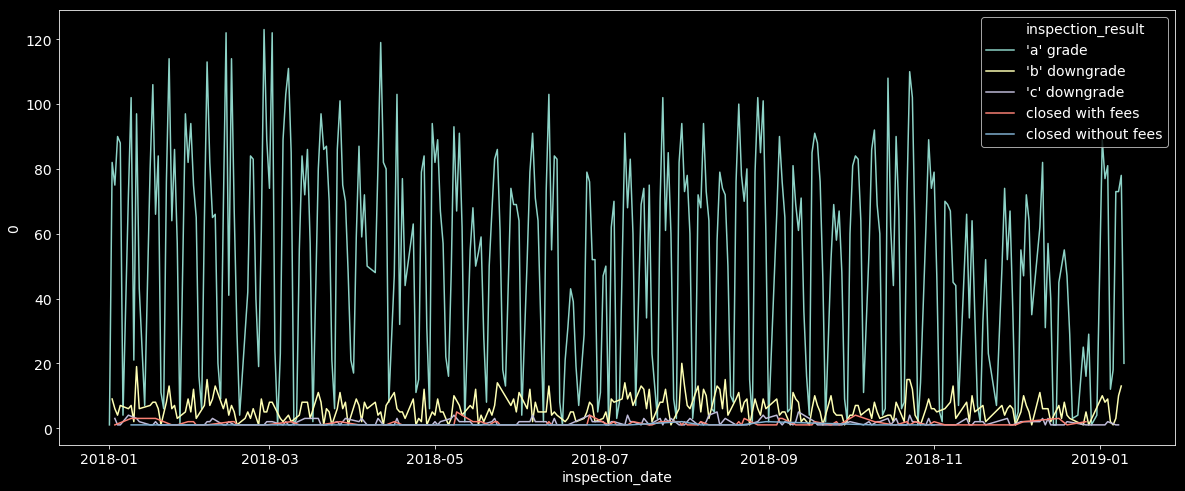

In [37]:
# set figure size and 
plt.rcParams["figure.figsize"] = [20,8]

# subset all inspections to include only those after 2018
inspection_frequency = nv.loc[nv['inspection_date']>= '2018', ['inspection_result', 'inspection_date']]

# count inspections by date and type
insp_freq = inspection_frequency.groupby(['inspection_date',  'inspection_result']).size().reset_index()

# plot
sns.lineplot(x='inspection_date', y=0, hue="inspection_result", data=insp_freq)

***
# Collect Yelp Data
In other to give more depth and perspective, Yelp data was added to the analysis. Although the Yelp data provides JSON files on business attributes, reviews, users, check-ins, tips and photos, only two files were used, the business data and reviews data.
Data files were retrieved directly from Yelp at https://www.yelp.com/dataset

In [38]:
# function to read Yelp JSON files
def read_yelp(json_file_path):
    """read each JSON object as a json file and append it to the yelp data list"""
    try:
        yelp_data = []
        with open(json_file_path, 'r') as file:
            for line in file:
                json_file = json.loads(line)
                yelp_data.append(json_file)
        return yelp_data
    except:
        print('File not found')

## business.json
Data source: https://www.yelp.com/dataset

In [39]:
# use user defined read_yelp function to read business.json
%time
yelp_data = read_yelp('yelp_academic_dataset_business.json')

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 28.8 µs


In [40]:
print(type(yelp_data))
yelp_data[0]

<class 'list'>


{'business_id': 'Apn5Q_b6Nz61Tq4XzPdf9A',
 'name': 'Minhas Micro Brewery',
 'neighborhood': '',
 'address': '1314 44 Avenue NE',
 'city': 'Calgary',
 'state': 'AB',
 'postal_code': 'T2E 6L6',
 'latitude': 51.0918130155,
 'longitude': -114.031674872,
 'stars': 4.0,
 'review_count': 24,
 'is_open': 1,
 'attributes': {'BikeParking': 'False',
  'BusinessAcceptsCreditCards': 'True',
  'BusinessParking': "{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}",
  'GoodForKids': 'True',
  'HasTV': 'True',
  'NoiseLevel': 'average',
  'OutdoorSeating': 'False',
  'RestaurantsAttire': 'casual',
  'RestaurantsDelivery': 'False',
  'RestaurantsGoodForGroups': 'True',
  'RestaurantsPriceRange2': '2',
  'RestaurantsReservations': 'True',
  'RestaurantsTakeOut': 'True'},
 'categories': 'Tours, Breweries, Pizza, Restaurants, Food, Hotels & Travel',
 'hours': {'Monday': '8:30-17:0',
  'Tuesday': '11:0-21:0',
  'Wednesday': '11:0-21:0',
  'Thursday': '11:0-21:0',
  'Friday'

In [41]:
# Normalize the JSON file to work with it in pandas
yelp_normalized = json_normalize(yelp_data)

### Subset business data for State of Nevada
Since the Yelp data includes over 180,000 business in 10 metropolitan areas, the business data is filter to include only the establishments in Nevada.

In [42]:
# subset relevant columns
business = yelp_normalized.copy()[['business_id','address', 'attributes.Alcohol',
                                  'attributes.Caters','attributes.DogsAllowed',
                                  'attributes.Open24Hours','attributes.RestaurantsDelivery',
                                  'attributes.Smoking','categories', 'city','state',
                                  'latitude', 'longitude', 'name','postal_code','review_count', 'stars']]

In [43]:
# look at the data count by state
%time
from collections import Counter
_ = Counter(business.state)
print(_)

CPU times: user 10 µs, sys: 9 µs, total: 19 µs
Wall time: 57.9 µs
Counter({'AZ': 56495, 'NV': 35688, 'ON': 32393, 'NC': 14359, 'OH': 13664, 'PA': 10966, 'QC': 8756, 'AB': 7670, 'WI': 5042, 'IL': 1937, 'SC': 770, 'NYK': 163, 'NI': 134, 'IN': 101, 'OR': 72, 'BY': 60, 'ST': 45, 'CO': 43, 'C': 34, 'HE': 32, 'XGM': 23, 'NLK': 23, 'RP': 19, 'NY': 19, '01': 11, 'CA': 8, 'VS': 7, 'NW': 4, '6': 3, 'O': 3, 'CMA': 2, 'SG': 2, 'G': 2, 'B': 2, 'VT': 2, 'AL': 2, 'MO': 2, 'M': 2, 'AR': 2, 'WA': 2, 'VA': 1, 'RCC': 1, '4': 1, '10': 1, 'CC': 1, '45': 1, 'LU': 1, 'MT': 1, 'PO': 1, 'WAR': 1, 'HU': 1, 'FL': 1, 'KY': 1, 'CRF': 1, 'TAM': 1, 'NE': 1, 'XMS': 1, 'GA': 1, 'AG': 1, 'WHT': 1, 'MA': 1, 'V': 1, 'BC': 1, 'SP': 1, 'DE': 1, 'HH': 1, '11': 1, 'CS': 1, 'MN': 1})


In [44]:
# filter data only for Nevada
business = business.loc[business.state== 'NV']

***
## review.json
Data source: https://www.yelp.com/dataset

In [45]:
review = read_yelp('yelp_academic_dataset_review.json')

In [46]:
# preview the lenght of the file
len(review)

5996996

In [47]:
# normalize reviews file
review_yelp = json_normalize(review)

***
## Merge Business and Review Yelp data

In [48]:
# confirm data loaded
print(review_yelp.shape)
print(business.shape)

(5996996, 9)
(35688, 17)


In [50]:
# keep only business_id, date and stars columns
review_yelp = review_yelp[['business_id','date','stars']]

In [52]:
# group review data by date and business id to get the daily stars rating average for each business 
#before merging it with the business data
r = review_yelp.groupby(['date','business_id',])['stars'].mean().reset_index()

In [53]:
#merge business and review data
yelp = pd.merge(left=business, right=r, on='business_id', how='inner')

***
# Merge Restaurant Inspections Data and Yelp

In [57]:
try:
    with open('nv_inspections.csv') as r:
        inspections = pd.read_csv(r, dtype = {'zip_code':str}, parse_dates = ['inspection_date'])
except:
    print('File not found')

## Data Wrangling Yelp

In [60]:
# remove spaces and change values to lower letter
yelp = col_cleanup(yelp, cols_list = ['name','address'])

# remove special characters
yelp['clean_name'] = rm_special_char(yelp['name'])

# split dates and create month and year columns
yelp = split_dates(yelp, col_date = 'date')

# convert postal code to string type for merge
yelp['postal_code'] = yelp['postal_code'].astype(str)

## Merge Clean datasets

In [61]:
results = pd.merge(inspections, yelp, left_on=['clean_name', 'year_str', 'month_str','zip_code'],
                   right_on=['clean_name', 'year_str','month_str', 'postal_code'])

In [62]:
results.shape

(35000, 42)

In [63]:
# change inspection results to lower case and remove white spaces using user defined function
results = col_cleanup(results, cols_list = ['inspection_result'])

In [64]:
# review the value counts for each type of inspection result
results['inspection_result'].value_counts()

compliant                            14365
'a' grade                            12138
'b' downgrade                         5481
'c' downgrade                         2272
closed with fees                       642
no further action                       44
unspecified                             33
approved                                11
follow up required                       8
closed without fees                      2
complaint invalid/unsubstantiated        2
non-compliant                            1
cease and desist                         1
Name: inspection_result, dtype: int64

In [65]:
# review the distribution of the targe variable
results['is_compliant'].value_counts()

1    26572
0     8428
Name: is_compliant, dtype: int64

# Additional Data Wrangling and Feature engineering

In [66]:
results.columns

Index(['address_x', 'category_name', 'city_x', 'current_demerits',
       'current_grade', 'employee_id', 'inspection_date', 'inspection_time',
       'inspection_demerits', 'inspection_grade', 'inspection_result',
       'violations', 'inspection_type', 'location_1.coordinates',
       'location_name', 'permit_status', 'restaurant_name', 'zip',
       'clean_name', 'year_str', 'month_str', 'zip_code', 'is_compliant',
       'business_id', 'address_y', 'attributes.Alcohol', 'attributes.Caters',
       'attributes.DogsAllowed', 'attributes.Open24Hours',
       'attributes.RestaurantsDelivery', 'attributes.Smoking', 'categories',
       'city_y', 'state', 'latitude', 'longitude', 'name', 'postal_code',
       'review_count', 'stars_x', 'date', 'stars_y'],
      dtype='object')

In [67]:
# rename column names
results = results.rename(columns = {'city_x': 'city','location_1.coordinates':'coordinates','attributes.Alcohol':'serve_alcohol',
                         'attributes.Caters':'caters','attributes.RestaurantsDelivery':'delivery',
                         'stars_x':'stars_business','stars_y':'stars_review','date':'review_date'})

In [68]:
# create binary variables based on the type of food establishment
def cat(df):
    """Create a new column based on category name and categories variables"""
    df = col_cleanup(df, ['category_name'])
    
    choicelist_two= ['1','1']
    choicelist_three = ['1','1','1']
    condsnack = [df['category_name'] == 'concessions', df['category_name'] == 'snack bar']
    condbar = [df['category_name'] =='bar / tavern',df['category_name'] =='beer bar']
    condbakery = [df['category_name'] =='kitchen bakery', df['category_name'] =='bakery', df['category_name'] =='confection']
    condlist = [df['category_name']=='portable unit', df['category_name']=='food trucks / mobile vendor']
    condcaterer = [df['category_name'] =='banquet kitchen', df['category_name'] =='caterer']
    condmex = [df['categories']]
    
    df['restaurant'] = np.where(df['category_name'] == 'restaurant', '1', '0')
    df['snack_bar'] = np.select(condlist=condsnack, choicelist=choicelist_two, default='0')
    df['bar'] = np.select(condlist=condbar, choicelist=choicelist_two, default='0')
    df['bakery_confection'] = np.select(condlist=condbakery, choicelist=choicelist_three, default='0')
    df['speciality'] = np.where(df['category_name'] == 'special kitchen', '1', '0')
    df['bbq'] = np.where(df['category_name'] == 'barbeque', '1', '0')
    df['buffet'] = np.where(df['category_name'] == 'buffet', '1', '0')
    df['portable_foodtruck'] = np.select(condlist=condlist, choicelist=choicelist_two, default='0')
    df['caterer'] = np.select(condlist=condcaterer, choicelist=choicelist_two)
    df['meat_poultry_seafood'] = np.where(df['category_name'] == 'meat/poultry/seafood', '1','0')
    df['japanese_yelp'] = np.where(df['categories'].str.contains('Japanese'), '1', '0')
    df['mexican_yelp'] = np.where(df['categories'].str.contains('Mex'), '1','0')
    df['latin_yelp'] = np.where(df['categories'].str.contains('Latin'), '1','0')
    df['vietnamese_yelp'] = np.where(df['categories'].str.contains('Vietnamese'), '1','0')
    df['thai_yelp'] = np.where(df['categories'].str.contains('Thai'),'1','0')
    df['chinese_yelp'] = np.where(df['categories'].str.contains('Chinese'),'1','0')
    df['vegan_yelp'] = np.where(df['categories'].str.contains('Veg'),'1','0')
    df['burguers_yelp'] = np.where(df['categories'].str.contains('Burger'),'1','0')
    df['bbq_yelp'] = np.where(df['categories'].str.contains('Barb'),'1','0')
    df['beer_yelp'] = np.where(df['categories'].str.contains('Beer'),'1','0')
    df['seafood_yelp'] = np.where(df['categories'].str.contains('Seafood'),'1','0')
    df['sandwich_yelp'] = np.where(df['categories'].str.contains('Sandwich'),'1','0')
    df['pizza_yelp'] = np.where(df['categories'].str.contains('Pizza'),'1','0')
    df['desserts_yelp'] = np.where(df['categories'].str.contains('Desser'),'1','0')
    df['italian_yelp'] = np.where(df['categories'].str.contains('Ital'),'1','0')
    return df

In [72]:
# create a new column with difference between review date and inspection date
def diff_dates(d1, d2):
    return(d2 - d1)

In [73]:
# apply user defined function
results['diff_dates'] = diff_dates(results['inspection_date'], results['review_date'])

In [74]:
# apply user defined function to create binary variables
results= cat(results)

In [75]:
results['is_compliant'].value_counts()

1    26572
0     8428
Name: is_compliant, dtype: int64

In [76]:
# select most relevant columns
results = results[['category_name', 'city', 'current_demerits','current_grade', 'employee_id', 'inspection_date', 'inspection_time',
                  'inspection_demerits', 'inspection_grade', 'inspection_result','violations', 'inspection_type', 'coordinates',
                  'clean_name', 'year_str','month_str','is_compliant','delivery', 'attributes.Smoking','categories',
                  'postal_code', 'review_count', 'stars_business', 'review_date','stars_business','stars_review','diff_dates',
                   'restaurant', 'snack_bar','bar', 'bakery_confection', 'speciality', 'bbq', 'buffet','portable_foodtruck',
                   'caterer', 'meat_poultry_seafood','japanese_yelp', 'mexican_yelp', 'latin_yelp', 'vietnamese_yelp',
                  'thai_yelp', 'chinese_yelp', 'vegan_yelp', 'burguers_yelp', 'bbq_yelp','beer_yelp', 'seafood_yelp',
                   'sandwich_yelp', 'pizza_yelp','desserts_yelp', 'italian_yelp']]

# Data Story Merged Data
Since Yelp data only includes commercial businesses, data on childcare and elementary kitchens is no longer available and the restaurants category makes up the majority of food establishments, as shown in the graph below.

### <b>How much does the distribution of the inspection results change after merging the datasets?</b>

One of the initial assumptions for this project was that the type of food establishment (e.g. restaurant, food truck, bar, etc.), could help explain inspection grades by providing different counts of violations for each category. However, the data show that the overwhelming majority of food establishments are restaurants. Hence, using this attribute to help predict health violation will biased the results as the information will mostly come from a single source, restaurants. 

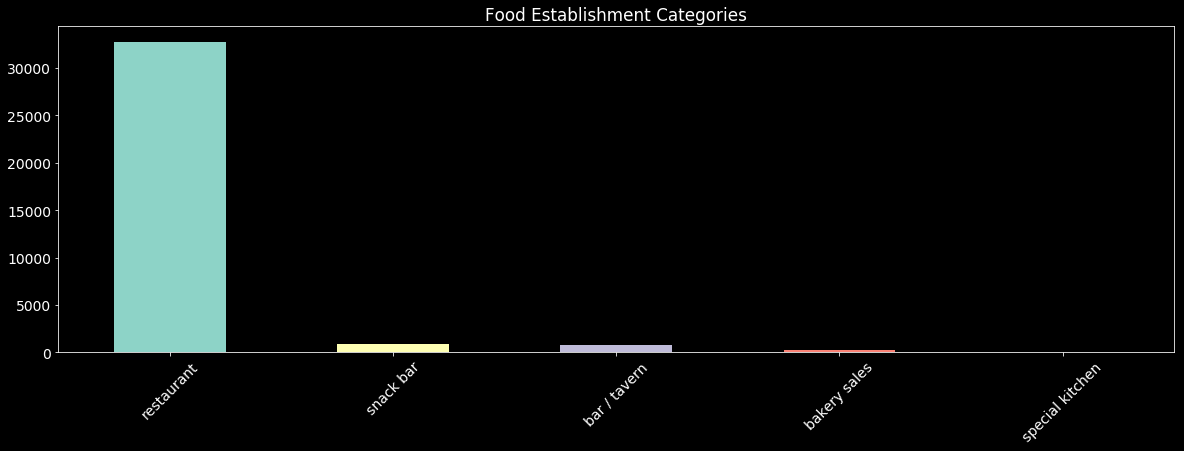

In [77]:
plt.rcParams["figure.figsize"] = [20,6]
plt.style.use(['dark_background'])
plt.rcParams.update({'font.size': 14})
plt.title('Food Establishment Categories')
results.category_name.value_counts().head().plot(kind = 'bar', rot = 45)

### <b>Inspection Results distribution</b>
Although the vast number of inspections resulted in being compliant, more than 6000 inspections resulted in downgrades.  

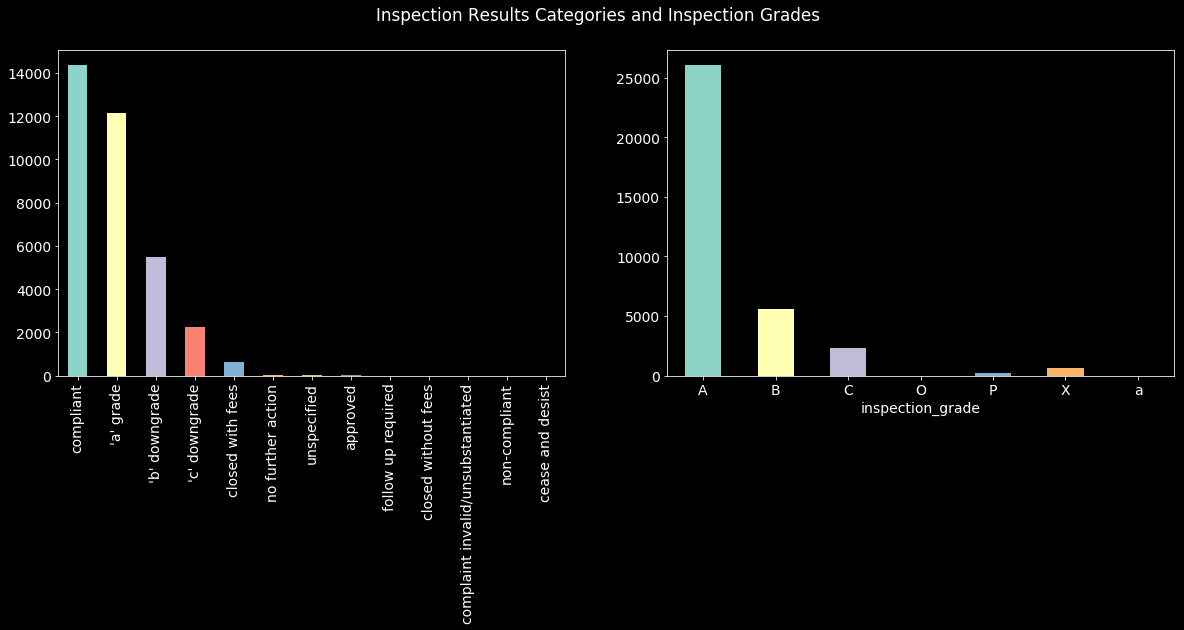

In [78]:
plt.style.use(['dark_background'])
plt.rcParams["figure.figsize"] = [20,6]
plt.rcParams.update({'font.size': 14})
plt.suptitle('Inspection Results Categories and Inspection Grades')
plt.subplot(1,2,1)
plt.style.use(['dark_background'])
results['inspection_result'].value_counts().plot(kind = 'bar', rot = 90)
plt.subplot(1,2,2)
results.groupby(['inspection_grade']).size().plot(kind = 'bar', rot = 0)

### <b>What is the Relation between the Number of Demerits and the Inspection Grade?</b>
As mentioned before, each violation is assigned a value (demerit), that results in a grade. The scatterplot below, shows that some demerits may carry different weight, since some inspections received an 'A', despite having over 10 demerits.

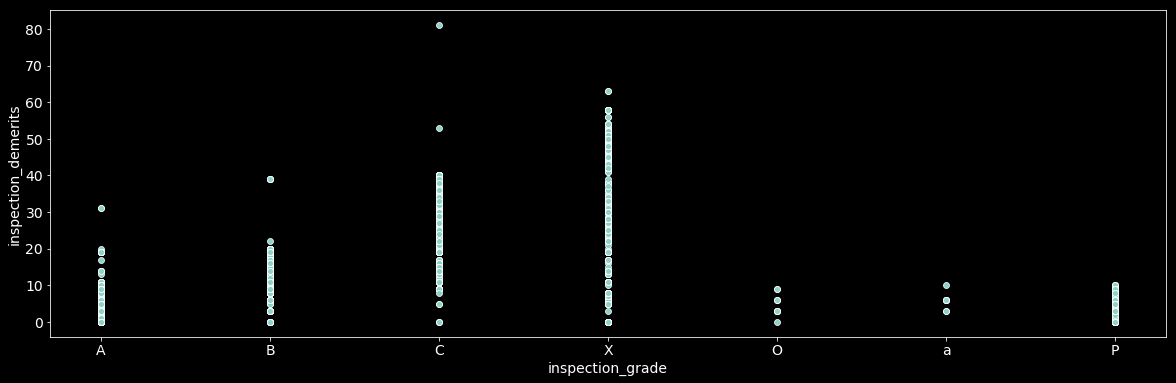

In [79]:
sns.scatterplot(results['inspection_grade'],results['inspection_demerits'])

### <b> Violation Codes Counts and Inspection Grades
By counting the number of violations recorded for each inspection, we can see that for the vast majority of inspections just between three and four violations codes are recorded. 

In [80]:
# split the violation codes into separate columns
violations = results['violations'].str.split(',', expand=True)

# create a new column with the total number of codes per row
violations['count'] = violations.count(axis = 1)

# fill the NAs
violations = violations.fillna('-')

# add prefix to each violation code variable
violations = violations.add_prefix('violation_')

# join the main dataset with the violations
results = pd.concat([results, violations], axis=1)

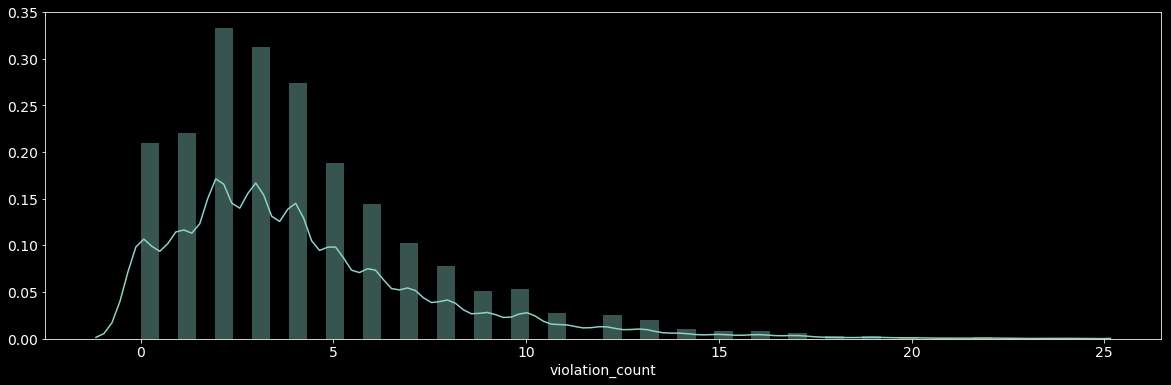

In [81]:
# histogram of violations count
sns.distplot(results['violation_count'])

Even though each violation type can affect the grade differently, the number of violations seems to be correlated to the grade received, with ‘o’, ‘a’, and ‘p’ grades having less than 10 demerits.

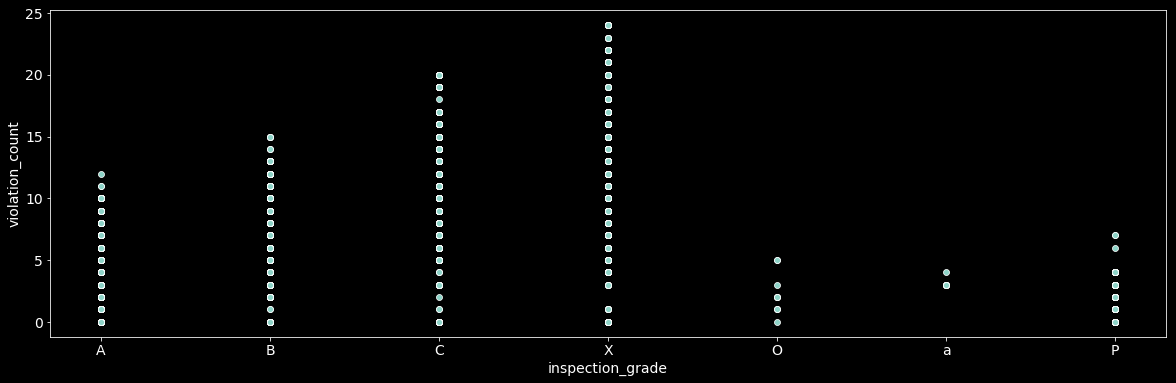

In [82]:
# sctterplot
sns.scatterplot(results['inspection_grade'], results['violation_count'])

### <b> Number of Violations per Inspection and Inspection Results
Since the majority of inspections have between 3 and 4 violations, by combining all the ‘compliant’ results, we can see that some violations may have a different weight when it comes to violation points.  

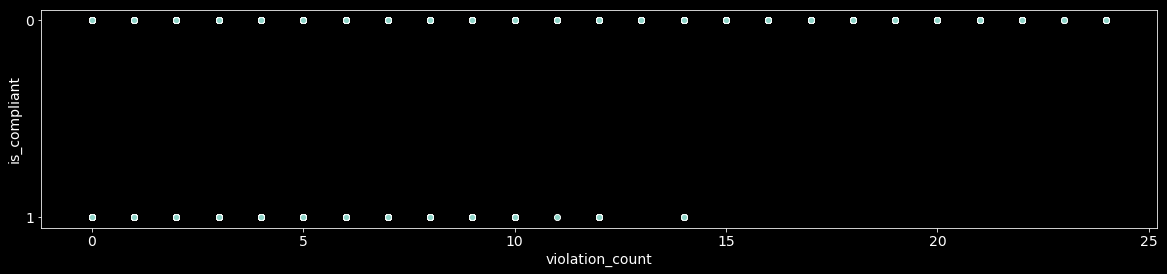

In [101]:
# change the target variable to a categorical variable
results['is_compliant'] = results['is_compliant'].astype('category')

# set the figure size and plot
plt.rcParams["figure.figsize"] = [20,4]
sns.scatterplot(results['violation_count'], results['is_compliant'],y_jitter = True)

### Users Ratings and Compliance Results

How do user ratings compare to compliance results? The graph below shows that the majority of food establishments with five start ratings receive a compliance result.

In [2]:
#from bokeh.plotting import figure 
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.transform import factor_cmap
from bokeh.palettes import GnBu3


In [103]:
output_file("inspections_results.html")

In [3]:
output_notebook()

Loading BokehJS ...

In [105]:
# round the stars review to 1 decimal
results['stars_review'] = results.stars_review.round(1)

# change the stars review column to str
results.stars_review = results.stars_review.astype(str)

In [106]:
ind_results = results.groupby(['is_compliant','stars_review']).size().reset_index()

# create new column with teh count and delete the column 0
ind_results['count'] = ind_results[0]
del ind_results[0]

group = ind_results.groupby(['is_compliant','stars_review'])
source = ColumnDataSource(group)
index_cmap = factor_cmap('is_compliant_stars_review', palette=GnBu3,factors=sorted(ind_results.stars_review.unique()), end=1)

p = figure(plot_width=1000, plot_height=400, title="Average User Rating by Compliance",
           x_range=group, toolbar_location=None, tools=" ")

p.vbar(x='is_compliant_stars_review', top='count_mean', width=1, source=source,
       line_color="white"), #fill_color=index_cmap, )

p.y_range.start = 0
p.x_range.range_padding = 0.05
p.xgrid.grid_line_color = None
p.xaxis.axis_label = "User Rating grouped by Compliance"
p.xaxis.major_label_orientation = 7.5
p.outline_line_color = None
show(p)